#  Использование одномерных сверток в PyTorch

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html#torch.nn.MaxPool1d
* https://wandb.ai/wandb_fc/wb-tutorials/reports/Tutorial-Text-Classification-Using-CNNs--Vmlldzo0NTIxNDI5
* https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

## Задачи для совместного разбора

1\. Изучите принцип работы одномерных сверточных слоев в `torch`

![1d conv](https://raw.githubusercontent.com/krzjoa/krzjoa.github.io/master/assets/img/2020-10-03-ts-and-torch-1/conv1d.gif)

![conv1d](https://www.macnica.co.jp/business/ai/blog/files/image5_2.png)

In [ ]:
import torch
import torch.nn as nn

# допустим, у нас есть вход: батч=1, канал=1, длина=10
x = torch.arange(10, dtype=torch.float32).view(1, 1, -1)
print("Вход:", x)

# создаём свёрточный слой:
# in_channels=1 (один временной ряд),
# out_channels=1 (один фильтр),
# kernel_size=3 (смотрим по 3 точки подряд)
conv1d = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, bias=False)

# вручную зададим веса фильтра (например [0.2, 0.5, 0.3])
conv1d.weight.data = torch.tensor([[[0.2, 0.5, 0.3]]])

y = conv1d(x)
print("Выход:", y)


Вход: tensor([[[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]])
Выход: tensor([[[1.1000, 2.1000, 3.1000, 4.1000, 5.1000, 6.1000, 7.1000, 8.1000]]],
       grad_fn=<ConvolutionBackward0>)


## Задачи для самостоятельного решения

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import re
import random
from collections import Counter
from sklearn.metrics import classification_report
import numpy as np



<p class="task" id="1"></p>

1\. Загрузите данные из файла `ts.csv`. Используя модель, состоящую из одного одномерного сверточного слоя, решите задачу предсказания $y_t$ по `k` предыдущим точкам временного ряда $x_{t-k}...x_{t-1}$. Исследуйте значения $k\in[1, 7]$. Для каждого $k$ выведите на экран итоговое значение функции потерь и веса ядра свертки. Визуализируйте исходный временной ряд и полученные прогнозы.

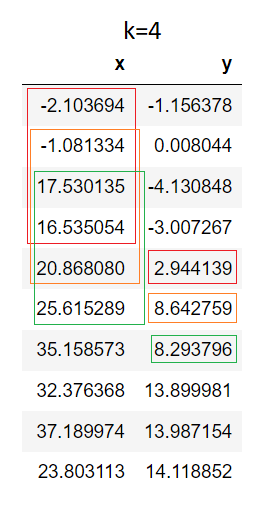
- [ ] Проверено на семинаре

k=1, loss=3.1305, weights=[0.39683005]
k=2, loss=1.9138, weights=[0.11682869 0.2838729 ]
k=3, loss=1.3918, weights=[-0.06536545  0.15546551  0.3085282 ]
k=4, loss=1.4188, weights=[-0.03611962 -0.02107155  0.10340861  0.3514099 ]
k=5, loss=0.2844, weights=[ 0.07069061 -0.08878374 -0.09886033  0.22648115  0.29004613]
k=6, loss=0.0000, weights=[-1.5902340e-05  1.0002000e-01 -1.4998767e-01 -5.0008610e-02
  1.9997479e-01  3.0002052e-01]
k=7, loss=0.6351, weights=[ 0.01969164 -0.05122203  0.10584982 -0.07501497 -0.07249519  0.12654743
  0.34706375]


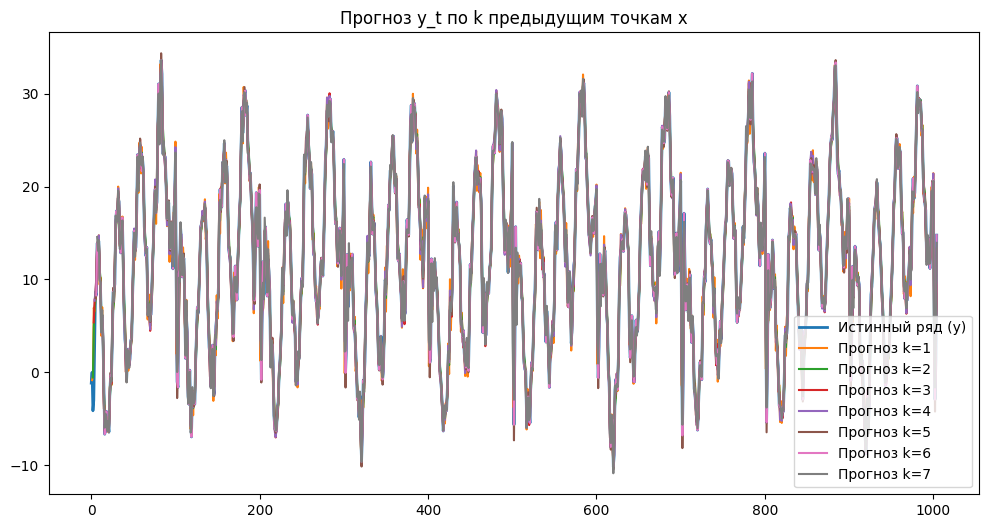

In [ ]:
df = pd.read_csv("data/ts.csv")
x = df["x"].values.astype("float32")
y = df["y"].values.astype("float32")

def make_dataset(x, y, k):
    X, Y = [], []
    for t in range(k, len(x)):
        X.append(x[t-k:t])   # k предыдущих x
        Y.append(y[t])       # текущее y
    X = torch.tensor(X).unsqueeze(1)   # (N, 1, k)
    Y = torch.tensor(Y)                # (N,)
    return X, Y

class ConvModel(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=k, bias=False)

    def forward(self, x):
        out = self.conv(x)   # (N,1,1)
        return out.squeeze()

results = {}

for k in range(1, 8):
    X, Y = make_dataset(x, y, k)

    model = ConvModel(k)
    optimizer = optim.Adam(model.parameters(), lr=0.05)
    criterion = nn.MSELoss()

    # обучение
    for epoch in range(200):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, Y)
        loss.backward()
        optimizer.step()

    final_loss = loss.item()
    kernel_weights = model.conv.weight.detach().numpy().flatten()

    results[k] = {
        "loss": final_loss,
        "weights": kernel_weights,
        "pred": y_pred.detach().numpy()
    }

    print(f"k={k}, loss={final_loss:.4f}, weights={kernel_weights}")

plt.figure(figsize=(12, 6))
plt.plot(y, label="Истинный ряд (y)", linewidth=2)

for k in results:
    pred = results[k]["pred"]
    # дополним NaN в начале для выравнивания по времени
    pred_full = [None]*k + pred.tolist()
    plt.plot(pred_full, label=f"Прогноз k={k}")

plt.legend()
plt.title("Прогноз y_t по k предыдущим точкам x")
plt.show()


<p class="task" id="2"></p>

2\. Загрузите файл `PV_Elec_Gas2.csv`. Опишите класс `ElectricityDataset`, который разбивает данные на окна в соответствии со следующей схемой:

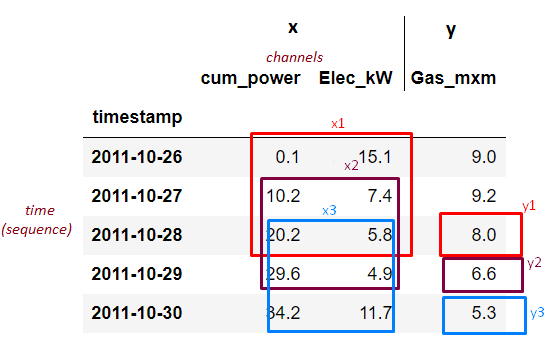

Разбейте набор данных на обучающую и тестовую выборку. Для теста оставьте данные за 2019 год.

- [ ] Проверено на семинаре

In [14]:
df = pd.read_csv("data/PV_Elec_Gas2.csv", parse_dates=["Unnamed: 0"])
df = df.rename(columns={"Unnamed: 0": "timestamp"})
df = df.sort_values("timestamp")

print(df.head())
print("Размерность:", df.shape)

class ElectricityDataset(Dataset):
    def __init__(self, df, window_size=3):
        self.X = []
        self.y = []
        
        values_x = df[["cum_power", "Elec_kW"]].values.astype("float32")
        values_y = df["Gas_mxm"].values.astype("float32")
        
        for t in range(window_size, len(df)):
            self.X.append(values_x[t-window_size:t])  # (window_size, 2)
            self.y.append(values_y[t])                # значение газа на следующий день
        
        self.X = torch.tensor(self.X)  # (N, window_size, 2)
        self.y = torch.tensor(self.y)  # (N,)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # Conv1d ожидает (channels, seq_len), поэтому транспонируем
        return self.X[idx].T, self.y[idx]

train_df = df[df["timestamp"] < "2019-01-01"]
test_df  = df[df["timestamp"] >= "2019-01-01"]

train_dataset = ElectricityDataset(train_df, window_size=3)
test_dataset  = ElectricityDataset(test_df, window_size=3)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

X0, y0 = train_dataset[0]
print("Форма X0:", X0.shape)   # (channels=2, seq_len=3)
print("y0:", y0)


   timestamp  cum_power  Elec_kW  Gas_mxm
0 2011-10-26        0.1     15.1      9.0
1 2011-10-27       10.2      7.4      9.2
2 2011-10-28       20.2      5.8      8.0
3 2011-10-29       29.6      4.9      6.6
4 2011-10-30       34.2     11.7      5.3
Размерность: (2948, 4)
Train samples: 2621
Test samples: 321
Форма X0: torch.Size([2, 3])
y0: tensor(6.6000)


<p class="task" id="3"></p>

3\. Решите задачу предсказания столбца `Gas_mxm` на основе столбцов `cum_power` и `Elec_kW` с использованием одномерных сверток. Для оптимизации используйте мини-пакетный градиентный спуск с использованием `DataLoader`. Обратите внимание, что при создании `DataLoader` вы не можете перемешивать данные.

Постройте график изменения значения функции потерь на обучающем и тестовом множестве в зависимости от номера эпохи. Визуализируйте на одном графике прогнозы модели и предсказываемый временной ряд.

- [ ] Проверено на семинаре

Epoch 10, Train Loss 115.9787, Test Loss 24.0757
Epoch 20, Train Loss 78.6683, Test Loss 201.9865
Epoch 30, Train Loss 83.0301, Test Loss 18.3612
Epoch 40, Train Loss 87.6110, Test Loss 33.8141
Epoch 50, Train Loss 52.2288, Test Loss 48.1554
Epoch 60, Train Loss 50.2502, Test Loss 56.5527
Epoch 70, Train Loss 40.1890, Test Loss 43.5183
Epoch 80, Train Loss 30.4890, Test Loss 35.5463
Epoch 90, Train Loss 42.4465, Test Loss 34.8260
Epoch 100, Train Loss 41.3803, Test Loss 34.6118


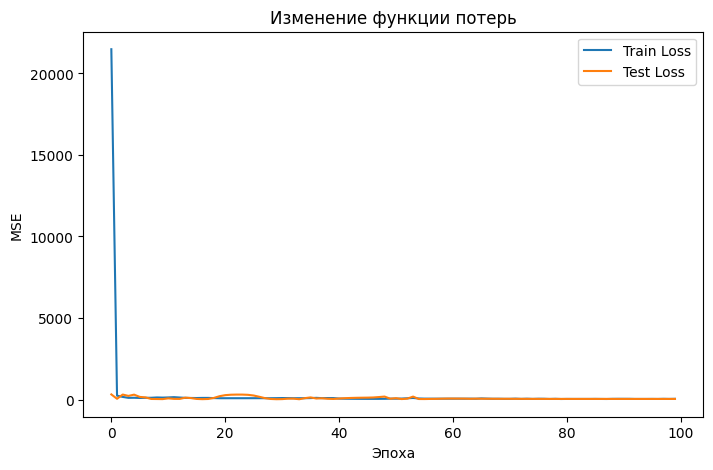

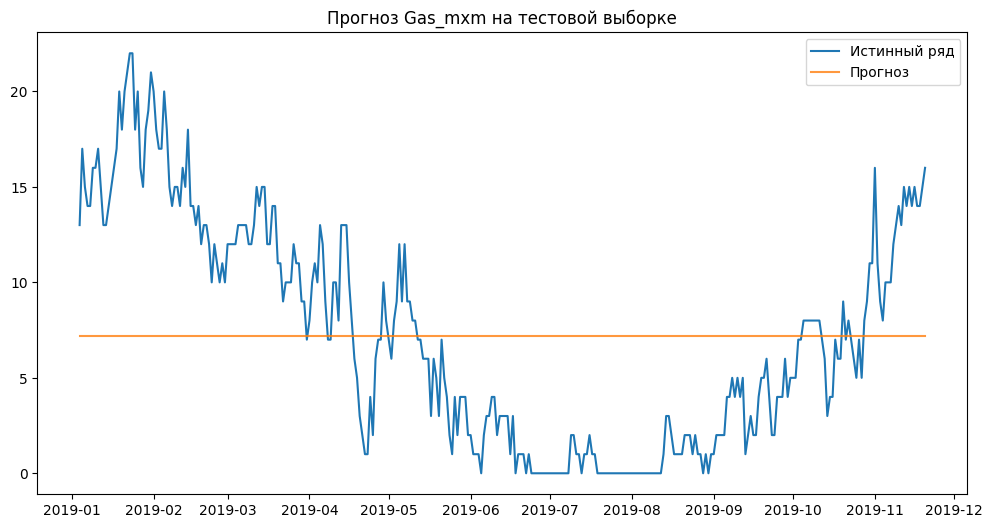

In [19]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class ConvForecastModel(nn.Module):
    def __init__(self, window_size):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=2, out_channels=8, kernel_size=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(8, 1)

    def forward(self, x):
        x = self.conv(x)          # (batch, 8, L)
        x = self.relu(x)
        x = self.pool(x)          # (batch, 8, 1)
        x = x.squeeze(-1)         # (batch, 8)
        x = self.fc(x)            # (batch, 1)
        return x.squeeze(-1)

window_size = 3
model = ConvForecastModel(window_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 100
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)
    train_losses.append(total_loss / len(train_dataset))


    model.eval()
    total_loss = 0
    preds = []
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            total_loss += loss.item() * len(xb)
            preds.append(pred)
    test_losses.append(total_loss / len(test_dataset))

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss {train_losses[-1]:.4f}, Test Loss {test_losses[-1]:.4f}")

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Эпоха")
plt.ylabel("MSE")
plt.legend()
plt.title("Изменение функции потерь")
plt.show()

model.eval()
all_preds = []
with torch.no_grad():
    for xb, yb in test_loader:
        all_preds.extend(model(xb).numpy())

plt.figure(figsize=(12,6))
plt.plot(test_df["timestamp"].iloc[window_size:].values, test_df["Gas_mxm"].iloc[window_size:].values, label="Истинный ряд")
plt.plot(test_df["timestamp"].iloc[window_size:].values, all_preds, label="Прогноз", alpha=0.8)
plt.legend()
plt.title("Прогноз Gas_mxm на тестовой выборке")
plt.show()


<p class="task" id="4"></p>

4\. Считайте файлы `polarity/positive_reviews.txt` (положительные обзоры на фильмы) и `polarity/negative_reviews.txt` (отрицательные обозоры на фильмы) и разбейте на обучающую и тестовую выборку. Выполните предобработку текста и создайте Vocab на основе обучающей выборки (токен - слово). Выведите на экран количество токенов в полученном словаре. 

Создайте класс `PolarityDataset` и реализуйте метод `__getitem__` таким образом, чтобы он возвращал набор индексов токенов (слов) для текста и метки классов для этих текстов. Создайте два объекта класса `PolarityDataset` для обучающей и тестовой выборки. Выведите на экраны количество элементов и распределение данных по классам в каждом из них.

- [ ] Проверено на семинаре

In [ ]:
def load_data(): # список всех текстов и их метки 
    with open("data/polarity/positive_reviews.txt", "r", encoding="utf-8") as f:
        pos = f.readlines()
    with open("data/polarity/negative_reviews.txt", "r", encoding="utf-8") as f:
        neg = f.readlines()
    texts = pos + neg
    labels = [1]*len(pos) + [0]*len(neg)
    return texts, labels

texts, labels = load_data()


def preprocess(text): # токенайзер простенький 
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # убираем знаки препинания
    tokens = text.split()
    return tokens

texts = [preprocess(t) for t in texts]

data = list(zip(texts, labels))
random.shuffle(data)

split = int(0.8 * len(data))
train_data, test_data = data[:split], data[split:]

train_texts, train_labels = zip(*train_data)
test_texts, test_labels = zip(*test_data)


counter = Counter([token for text in train_texts for token in text]) # частность слов
vocab = {token: idx+2 for idx, (token, _) in enumerate(counter.items())}
vocab["<PAD>"] = 0 # до одинаковой длина
vocab["<UNK>"] = 1 # для слов которых не было 

print("Размер словаря:", len(vocab))


class PolarityDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def encode(self, tokens):
        return [self.vocab.get(tok, self.vocab["<UNK>"]) for tok in tokens]

    def __getitem__(self, idx): 
        tokens = self.texts[idx]
        indices = self.encode(tokens)
        label = self.labels[idx]
        return torch.tensor(indices), torch.tensor(label) #список индексов слов, метку класса (0 или 1)

train_dataset = PolarityDataset(train_texts, train_labels, vocab)
test_dataset  = PolarityDataset(test_texts, test_labels, vocab)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

print("Train class balance:", sum(train_labels), "positive,", len(train_labels)-sum(train_labels), "negative")
print("Test class balance:", sum(test_labels), "positive,", len(test_labels)-sum(test_labels), "negative")


Размер словаря: 18213
Train size: 8529
Test size: 2133
Train class balance: 4242 positive, 4287 negative
Test class balance: 1089 positive, 1044 negative


<p class="task" id="5"></p>

5\. Решите задачу классификации текстов обзоров с использованием одномерных сверток. Для преобразования последовательности индексов в последовательность векторов используйте слой `nn.Embedding`. Обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`. Выведите на экран отчет по классификации для обучающей и тестовой выборки после завершения процесса обучения. Добейтесь accuracy на тестовой выборке не менее 70%.

- [ ] Проверено на семинаре

In [ ]:
vocab_size = len(vocab)
embedding_dim = 100
batch_size = 32
n_epochs = 20
max_len = 200   # ограничим длину обзора

def collate_batch(batch):
    texts, labels = zip(*batch)
    lengths = [len(t) for t in texts]
    max_length = min(max(lengths), max_len)

    padded = torch.zeros(len(texts), max_length, dtype=torch.long)
    for i, seq in enumerate(texts):
        end = min(len(seq), max_length)
        padded[i, :end] = seq[:end]

    return padded, torch.tensor(labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(100, num_classes)

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)              # (batch, seq_len, embedding_dim)
        x = x.permute(0, 2, 1)             # (batch, embedding_dim, seq_len)
        x = self.conv(x)                   # (batch, 100, L)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)       # (batch, 100)
        x = self.fc(x)                     # (batch, num_classes)
        return x

model = CNNTextClassifier(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss {total_loss/len(train_loader):.4f}")

def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            pred = model(xb)
            preds = torch.argmax(pred, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

y_true_train, y_pred_train = evaluate(train_loader)
y_true_test, y_pred_test   = evaluate(test_loader)

print("=== Train report ===")
print(classification_report(y_true_train, y_pred_train, digits=3))

print("=== Test report ===")
print(classification_report(y_true_test, y_pred_test, digits=3))


Epoch 1, Loss 0.6602
Epoch 2, Loss 0.4963
Epoch 3, Loss 0.3120
Epoch 4, Loss 0.1522
Epoch 5, Loss 0.0616
Epoch 6, Loss 0.0249
Epoch 7, Loss 0.0128
Epoch 8, Loss 0.0078
Epoch 9, Loss 0.0053
Epoch 10, Loss 0.0037
Epoch 11, Loss 0.0028
Epoch 12, Loss 0.0021
Epoch 13, Loss 0.0016
Epoch 14, Loss 0.0013
Epoch 15, Loss 0.0010
Epoch 16, Loss 0.0008
Epoch 17, Loss 0.0007
Epoch 18, Loss 0.0006
Epoch 19, Loss 0.0005
Epoch 20, Loss 0.0004
=== Train report ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      4287
           1      1.000     1.000     1.000      4242

    accuracy                          1.000      8529
   macro avg      1.000     1.000     1.000      8529
weighted avg      1.000     1.000     1.000      8529

=== Test report ===
              precision    recall  f1-score   support

           0      0.703     0.732     0.717      1044
           1      0.732     0.703     0.718      1089

    accuracy                         

<p class="task" id="6"></p>

6\. Придумайте небольшой отзыв, прогоните его через модель и выведите метку предсказанного класса (позитивный или негативный). Сделайте это для явно позитивного и явно негативного отзыва.

- [ ] Проверено на семинаре

In [ ]:
def encode_text(text, vocab, max_len=200):
    tokens = preprocess(text)  # используем тот же препроцесс
    indices = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens]
    # паддинг
    if len(indices) < max_len:
        indices = indices + [vocab["<PAD>"]] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return torch.tensor(indices).unsqueeze(0)  # (1, seq_len)

def predict(text):
    model.eval()
    x = encode_text(text, vocab)
    with torch.no_grad():
        logits = model(x)
        pred = torch.argmax(logits, dim=1).item()
    return "Positive" if pred == 1 else "Negative"

positive_review = "I really loved this movie, it was fantastic and emotional!"
negative_review = "This film was boring, tedious and a complete waste of time."

print("Positive review:", positive_review)
print("Predicted:", predict(positive_review))

print("Negative review:", negative_review)
print("Predicted:", predict(negative_review))


Positive review: I really loved this movie, it was fantastic and emotional!
Predicted: Positive
Negative review: This film was boring, tedious and a complete waste of time.
Predicted: Negative


## Обратная связь
- [ ] Хочу получить обратную связь по решению